In [8]:
import scipy
import pandas as pd
import numpy as np
import astropy
import astropy.coordinates as ac
import astropy.units as u
import pylab as plt
import seaborn as sns
%matplotlib inline

In [9]:
import galstreams

In [10]:
mws = galstreams.MWStreams(verbose=False, implement_Off=True)

Initializing galstreams library from master_log... 


Write your base query here, the polygon part gets written automatically

In [38]:
base_query = """SELECT *
FROM gaiadr3.gaia_source_lite
WHERE 
"""

# For quick tests maybe selecte a random sampling
#  base_query = """SELECT *
# FROM gaiadr3.gaia_source_lite
# WHERE 
# mod(random_index,100)=0 
# AND
# """

100.03048012828123
11


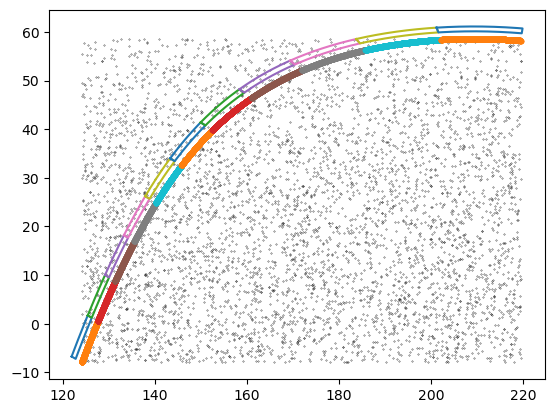

In [40]:
st = 'GD-1-PB18'

#Generate random points on the sphere in an area around the track
rao,raf = np.min(mws[st].track.ra.deg), np.max(mws[st].track.ra.deg)
deco,decf = np.min(mws[st].track.dec.deg),np.max(mws[st].track.dec.deg)
field_ra, field_dec = galstreams.get_random_spherical_angles(5000,az=[rao,raf],
                                                           lat=[deco,decf],degree=True)
field = ac.SkyCoord(ra=field_ra*u.deg, dec=field_dec*u.deg, frame='icrs')
plt.plot(field.ra, field.dec, 'k.', ms=0.5)

#CHop up polygon into <20deg chunks and generate adql query for each
print(mws[st].length.deg)
Nchunks = np.int32(np.ceil(mws[st].length/(10.*u.deg)))
n = np.int32(mws[st].track.size/Nchunks)
print(Nchunks)
query_lists = []
plt.plot(mws[st].track.ra,mws[st].track.dec,'k.',ms=0.5)
for i in range(Nchunks):
    #Split track into chunks
    tr = mws[st].track[i*n:(i+1)*n]
    poly = galstreams.create_sky_polygon_footprint_from_track(tr, mws[st].stream_frame, phi2_offset=2.*u.deg)
    #The plots are just to have a look
    plt.plot(poly.icrs.ra,poly.icrs.dec)
    plt.plot(tr.ra,tr.dec,'.')

    myquery=galstreams.get_adql_query_from_polygon(tr, base_query=base_query)
    query_lists.append(myquery)
    

    

In [36]:
from astroquery.gaia import Gaia

In [37]:
for j in range(len(query_lists))[:3]:
    myquery = query_lists[j]
    print(f"Printing query to file adql_test.{st}.poly{j}.csv")
    job = Gaia.launch_job_async(myquery, dump_to_file=True, output_format="csv", verbose=True, 
                                output_file=f"adql_test.{st}.poly{j}.csv")


Printing query to file adql_test.GD-1-PB18.poly0.csv
Launched query: 'SELECT *
FROM gaiadr3.gaia_source_lite
WHERE 

      1 = CONTAINS(POINT(ra, dec), 
                   POLYGON(124.065, -7.97077, 124.101, -7.87669, 124.138, -7.78264, 124.175, -7.68861, 124.212, -7.5946, 124.249, -7.50061, 124.286, -7.40665, 124.323, -7.31271, 124.36, -7.21879, 124.397, -7.1249, 124.434, -7.03102, 124.472, -6.93717, 124.509, -6.84334, 124.546, -6.74954, 124.583, -6.65576, 124.621, -6.56199, 124.658, -6.46825, 124.695, -6.37454, 124.733, -6.28084, 124.77, -6.18717, 124.808, -6.09351, 124.845, -5.99988, 124.883, -5.90627, 124.921, -5.81269, 124.958, -5.71912, 124.996, -5.62558, 125.034, -5.53205, 125.071, -5.43855, 125.109, -5.34507, 125.147, -5.25161, 125.185, -5.15817, 125.223, -5.06475, 125.261, -4.97135, 125.298, -4.87798, 125.336, -4.78462, 125.374, -4.69129, 125.413, -4.59797, 125.451, -4.50468, 125.489, -4.41141, 125.527, -4.31815, 125.565, -4.22492, 125.603, -4.13171, 125.642, -4.03852, 125.68,

Visualize the result

GD-1-PB18


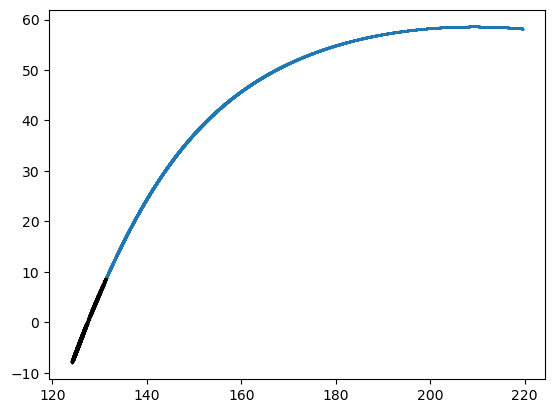

In [42]:
print(st)
for j in range(len(query_lists))[:2]:

    dat = astropy.table.Table.read(f"adql_test.{st}.poly{j}.csv",format='csv')
    plt.plot(dat['ra'],dat['dec'],'k.',ms=2.5, zorder=10)
    #Plot the track
    ax = plt.subplot(111)
    ax.plot(mws[st].track.ra, mws[st].track.dec, '.', ms=1.,color='C0')
